# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 20.11.2020

Мягкий дедлайн: 00:59MSK 02.12.2019

Жесткий дедлайн: 00:59MSK 07.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [15]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.031773447043214

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [29]:
import random

In [71]:
from sklearn.linear_model import LinearRegression

In [718]:
def compute_biase_variance1(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    num_oob = np.zeros(X.shape[0])
    sum_oob = np.zeros(X.shape[0])
    average_oob = np.zeros(X.shape[0])
    ### your code here
    
    error = 0
    variance = 0
    
    cur_num = 0
    
    cur_num_var = 0
    
    data_out = []
    data_predict = []
    df_out = pd.DataFrame()
    df_predict = pd.DataFrame()

    # генерация S выборок методом бутстрапа
    for i in range(num_runs): 
        first = np.arange(X.shape[0])

        sample = np.random.choice(X.shape[0],size = X.shape[0])
        regr = regressor.fit(X[sample], y[sample])
        

        out = list(set(first)-set(sample))

        df1 = pd.DataFrame(np.array(out))
        df_out = pd.concat([df_out,df1], ignore_index=True, axis=1)
        #data_out.append(out)
        
        pred_out = regressor.predict(X[out]) # predicted value h_b(x) for each x in T_b
        df2 = pd.DataFrame(np.array(pred_out))
        df_predict = pd.concat([df_predict,df2], ignore_index=True, axis=1)
        
        #data_predict.append(pred_out)
        
        error += np.dot((pred_out - y[out]).T,pred_out - y[out])
        
        cur_num += len(pred_out)
        num_oob[out] += 1 # в arr будет храниться количество вхождений каждого элемента - который не входил в выборку
        sum_oob[out]+= pred_out #тут сумма объектов, которые не входят в выборку

        
    average_oob = sum_oob/num_oob
    average_oob = np.insert(average_oob, len(average_oob), 0) # костыль - чтобы сравнять разные длины массивов
    y = np.insert(y, len(y), 0)
    
    df_out = df_out.fillna(X.shape[0]) # чтобы потом вычитать 0-0 не давало никакой вклад
    df_out = df_out.astype(int)
    df_out = df_out.to_numpy()
    
    outs = average_oob[df_out]
    
    df_predict = df_predict.fillna(0) # костыль чтобы сравнять размерности этого массива
    df_predict = df_predict.to_numpy()
    
    variance = np.trace(np.dot((df_predict - outs).T,df_predict - outs)) # сумма диагональных элементов - там как раз лежит скалярное произведение стобцов
    
    smes = np.dot((average_oob-y).T, average_oob-y)

    
    #variance1 = 0
    #for i in range(len(data_out)): можно было сделать так  разброс- без костылей, но с циклом
        
     #   variance1 += np.dot((data_predict[i] - average_oob[data_out[i]]).T,data_predict[i] - average_oob[data_out[i]])
        
    
    return smes/X.shape[0],error/cur_num, variance/cur_num
        

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [ ]:
### your code here

In [719]:
smes, error, variance, aveg = compute_biase_variance1(LinearRegression(), X, y)

In [720]:
aveg

array([30.13630658, 25.04472936, 30.55568053, 28.59729578, 27.91186409,
       25.21434845, 22.95765499, 19.25362796, 11.15904508, 18.802628  ,
       19.11932086, 21.56308667, 20.89160736, 19.55113058, 19.28456354,
       19.27157461, 20.5345198 , 16.88697825, 16.05428557, 18.40651311,
       12.44544992, 17.64422566, 15.84881509, 13.75733678, 15.63634423,
       13.30688692, 15.36263347, 14.68699842, 19.55512361, 20.8590529 ,
       11.34223054, 18.06773531,  8.63123216, 14.26660786, 13.68609586,
       23.82613513, 22.32653056, 23.14987893, 22.92751593, 31.30169041,
       34.21905547, 28.13367305, 25.29955758, 24.65933209, 22.99459952,
       22.10036359, 20.39081121, 18.0547855 ,  8.79580233, 17.12482645,
       21.29130226, 23.99597918, 27.70819712, 24.03712896, 15.02270746,
       31.00751979, 24.86214296, 33.10565136, 21.79281117, 21.07155268,
       17.80898023, 18.54665226, 24.03532202, 22.54450778, 22.97371142,
       30.47959418, 25.6671881 , 21.09348669, 17.3757334 , 20.77

In [554]:
smes, error, variance = compute_biase_variance1(LinearRegression(), X, y)

In [555]:
print(smes, error, variance)

23.765410677829493 24.755969263657637 0.93543128053275


Для регрессии смещение в разы больше чем разброс, что согласуется с интуицией с лекции. Линейные модели несильно отклоняются друг от друга - соответственно низкий разброс, и как правило плохо предсказывают истинную зависимость => большое смещение.

In [262]:
from sklearn.tree import DecisionTreeRegressor

In [556]:
from sklearn.tree import DecisionTreeClassifier
smes, error, variance = compute_biase_variance1(DecisionTreeRegressor(), X, y)

In [ ]:
smes, error, variance = compute_biase_variance1(DecisionTreeRegressor(), X, y)

In [557]:
print(smes, error, variance)

10.353105908058213 23.344611596197712 12.99667499222341


ОТсюда видно что разброс большой. Это следует из-за того, что решающее дерево сильно переобучается под единичные объекты. Смещение же как видно меньше чем в регрессии. Происходит из-за того, что дерево довольно хорошо подстраивается под изначальную выборку.


In [267]:
from sklearn.ensemble import RandomForestRegressor

In [560]:
smes, error, variance = compute_biase_variance1(RandomForestRegressor(), X, y)

In [561]:
print(smes, error, variance)

10.435654121827561 12.509720928375392 2.1218236197349745


Как видно смещение в RF такое же как и для одного решающего дерева. RF строится с помощью бэггинга. На лекции показывали, что смещение бэггинга такое же как и для одной модели. Результат согласуется с теорией.
Разброс же стал меньше, что также согласуется с лекцией -> разброс будет больше уменьшаться, если будут менее коррелированны выборки.(Выводили что второя слагаемое - это ковариация двух выборок, умноженная на коэффициент)

__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?


__Your answer here:__ Походу дела комментировал

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

Из лекций формула разброса для бэггинга: дисперсия одного алгоритма, деленная на длину композиции N. Второе - ковариация между двумя базовыми алгоритмами. Если базовые алгоритмы некоррелированны, то дисперсия композиции в N раз меньше отдельных алгоритмов. Но как правило корреляция неизбежна => поэтому не такое сильное уменьшение разброса должно наблюдаться.

In [771]:
def bagging(regressor, X, y, num_runs=100): # поменяю до num_runs=100, ибо иначе будет работать очень долго
    
    num_oob = np.zeros(X.shape[0])
    sum_oob = np.zeros(X.shape[0])
    average_oob = np.zeros(X.shape[0])
    
    error = 0
    variance = 0
    
    cur_num = 0
    
    cur_num_var = 0
    
    df_predict = pd.DataFrame()

    # генерация S выборок методом бутстрапа
    for i in range(num_runs): 
        first = np.arange(X.shape[0])
        
        num_oob_cur = np.zeros(X.shape[0])
        sum_oob_cur = np.zeros(X.shape[0])
        average_oob_cur = np.zeros(X.shape[0])
        
        y_oob_cur = np.zeros(X.shape[0])
        
        
        for j in range(100): # возьму для бэггинга 100 моделей
        
            sample = np.random.choice(X.shape[0],size = X.shape[0])
            regr = regressor.fit(X[sample], y[sample])
        

            out = list(set(first)-set(sample))
            pred_out = regressor.predict(X[out])
            
            num_oob[out] += 1 #будет храниться количество вхождений каждого элемента - который не входил в выборку
            sum_oob[out]+= pred_out #тут сумма объектов, которые не входят в выборку
            
            num_oob_cur[out] += 1 # счетчик для усреднения по беггингу
            sum_oob_cur[out]+= pred_out 
            
            y_oob_cur[out] += y[out]
            
            
            
        y_oob_cur =   y_oob_cur/num_oob_cur
        
        average_oob_cur = sum_oob_cur/num_oob_cur # это предсказания модели для 1 итерации бэггинга
        df2 = pd.DataFrame(np.array(average_oob_cur))

        
        df_predict = pd.concat([df_predict,df2], ignore_index=True, axis=1)
        
  
        error += np.dot((average_oob_cur - y_oob_cur).T,average_oob_cur - y_oob_cur)
        
        cur_num += len(average_oob_cur)

        
    average_oob = sum_oob/num_oob
    
    df_predict = df_predict.to_numpy()
    smes = np.dot((average_oob-y).T, average_oob-y)
    
    average_oob.shape += (1,) # сделать столбец вместо строчки
    variance = np.trace(np.dot((df_predict - average_oob).T,df_predict - average_oob)) # сумма диагональных элементов - там как раз лежит скалярное произведение стобцов
    
    #smes = np.dot((average_oob-y).T, average_oob-y)

    
    return smes/X.shape[0],error/cur_num, variance/cur_num
        

In [765]:
smes, error, var = bagging(LinearRegression(), X, y)

In [766]:
print(smes, error, var)

23.7416077963248 23.767405021470488 0.025761102186379125


Как видно для для линейной регрессии беггинг дает такое же смещение. Разброс же, хоть и был маленьким - уменьшился в 50 раз. Был 0.93543128053275 стал 0.025761102186379125. То есть модели довольно сильно некоррелированы.


In [767]:
smes, error, variance = bagging(DecisionTreeRegressor(), X, y)

In [769]:
print(smes, error, variance)

10.228519952392812 10.594441079354278 0.3681137684998304


Смещение такое же как и было. Разброс упал с  12.99667499222341 до 0.3681137684998304. Все согласуется с формулами.

In [772]:
smes, error, variance = bagging(RandomForestRegressor(), X, y)

In [773]:
print(smes, error, variance)

10.620332817118166 10.68323806652064 0.06210388470970731


10.435654121827561 12.509720928375392 2.1218236197349745 
Как видно смещение практически такое же. Разброс же стал в разы меньше. Также объясняется тем, что модели плохо коррелированы. Если были бы сильнее коррелированы, разброс был бы меньше, но не настолько сильно.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [699]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    ### your code here
    x_scale = np.arange(10)
    first = np.arange(X.shape[0])
    test = np.random.choice(X.shape[0],size = num_test_objects)
    train = list(set(first)-set(test))
    X_test = X[test]
    y_test = y[test]
    X_train = X[train]
    y_train = y[train]
    df = pd.DataFrame(columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    
    for i in range(num_runs):
        sample = np.random.choice(X_train.shape[0],size = X_train.shape[0])
        
        regr = regressor.fit(X_train[sample], y_train[sample])
        
        pred_out = regressor.predict(X_test)
        df.loc[i] = pred_out
    

    fig, ax = plt.subplots()
    fig.set_figwidth(6)    
    fig.set_figheight(4) 
    
    for i  in range(num_test_objects):
        ax.scatter([i]*100, df[df.columns[i]],c = 'r')
        
    for i  in range(num_test_objects): 
        ax.scatter([i], y_test[i],c = 'black')


    ax.set_title(title, fontsize=8)

    ax.set_xlabel("Объекты тестовой выборки", fontsize=8)
    ax.set_ylabel('Предсказания объектов тестовой выборки', fontsize=8)
    
    plt.show()
  
    #plt.scatter(df, x_scale)
    return num_runs

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

Сделал в столбик, так как есть масштаб и они следуют друг за другом, график имеет смысл.

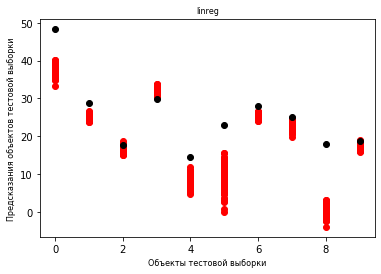

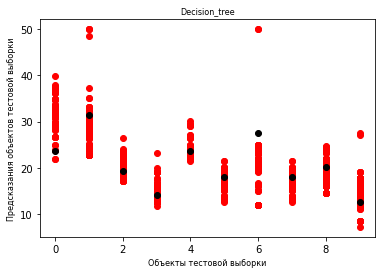

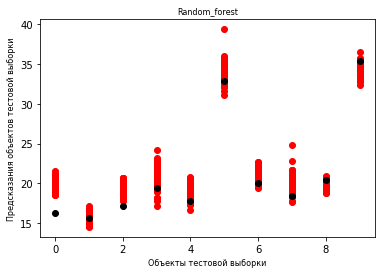

In [689]:
### your code here
el = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
el_title = ['linreg', 'Decision_tree', 'Random_forest']

for j  in range(3):

    plot_predictions(el[j], X, y, title = el_title[j], i = j)


__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

Из графика видно, что у Decision Tree большой разброс - так как некоторые объекты сильно отклоняются в обе стороны.(Объекты 1 6 9) И действительно, посмотрев на значения разброса выше - получу, что он получился наибольшим.
Также у RF для объекта 5 и 7 виден разброс. По посчитанным данным он больше чем у лин регресии. Но гораздо меньше чем у DF. Что согласуется с рисунком.

Для линейной регрессии видно, что данные плотненько расположены => разброс очень низкий.

По данным графикам у Decision Tree минимальное смещение, ибо черные точки попадают приблизительно в центр красного распределения.
Для RF картина для смещения примерно аналогичная как и для DT.(Черные точки попадают довольно неплохо в красный центр распределения). Для ли рег же для объектов 0, 1, 4, 5, 8 -> значения таргета довольно далеко находится от центра красного распределения(от предсказанных знаечний беггинга) => самое большое смещение среди трех моделей.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [672]:
X.shape[1]

13

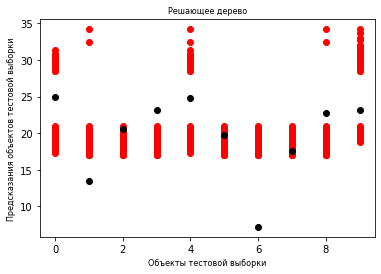

max_depth =  1


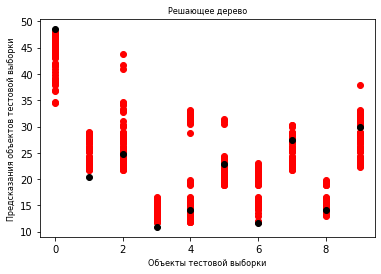

max_depth =  2


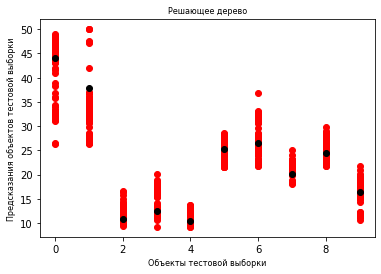

max_depth =  3


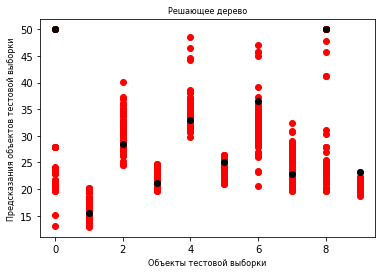

max_depth =  4


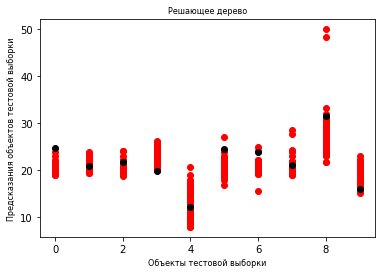

max_depth =  5


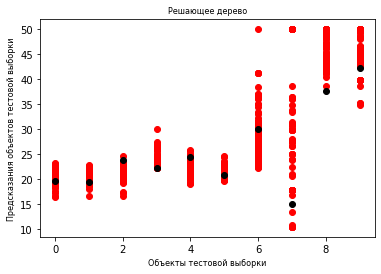

max_depth =  6


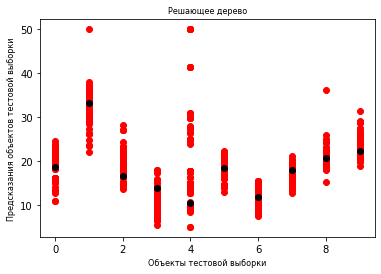

max_depth =  7


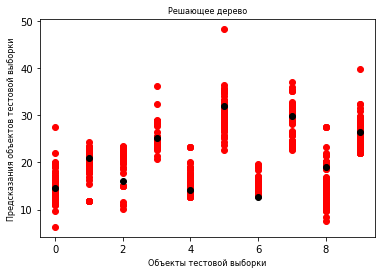

max_depth =  8


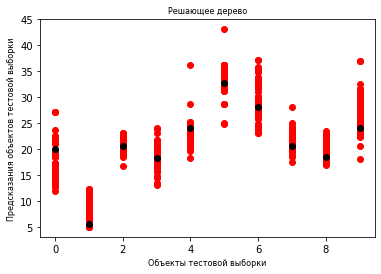

max_depth =  9


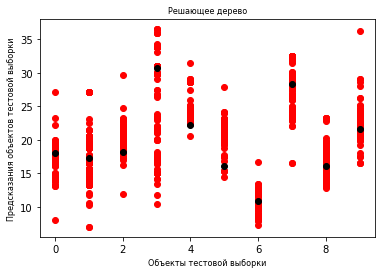

max_depth =  10


In [669]:
for j  in range(1, 11):

    plot_predictions(DecisionTreeRegressor(max_depth = j), X, y, title = "Решающее дерево")
    print("max_depth = ", j)



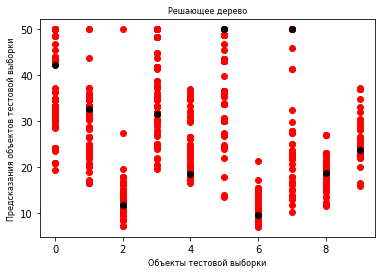

max_features =  1


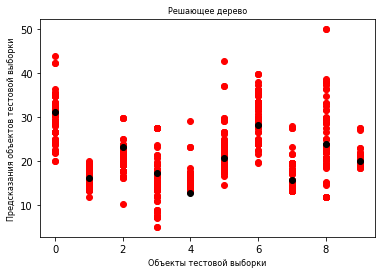

max_features =  2


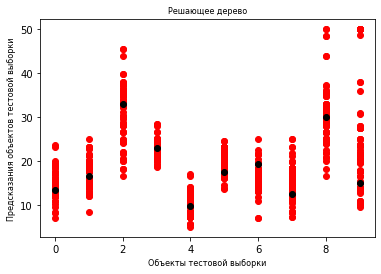

max_features =  3


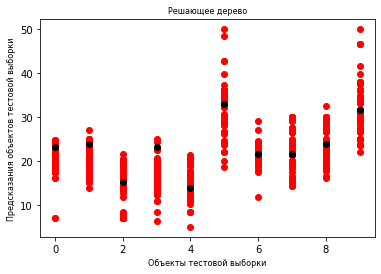

max_features =  4


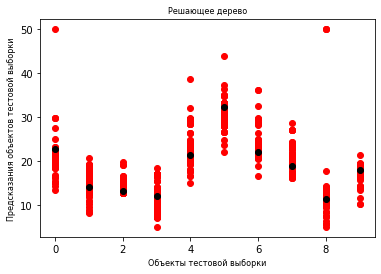

max_features =  5


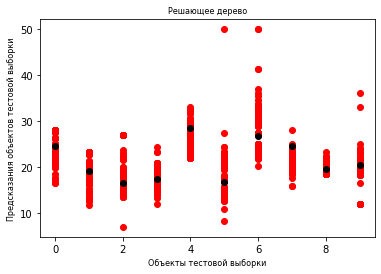

max_features =  6


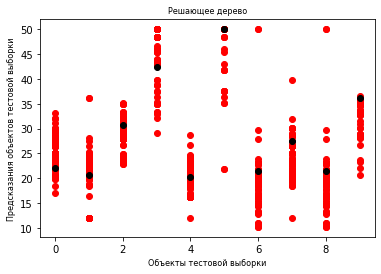

max_features =  7


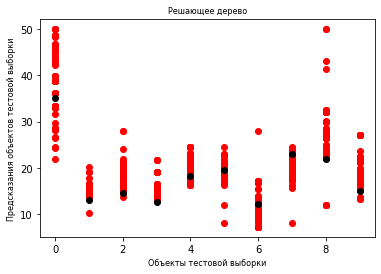

max_features =  8


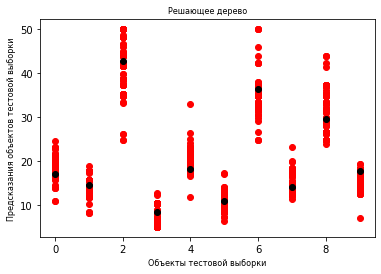

max_features =  9


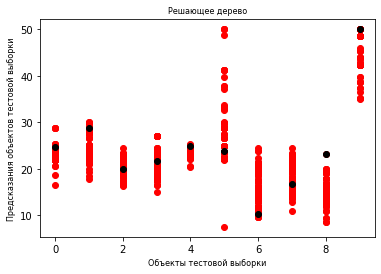

max_features =  10


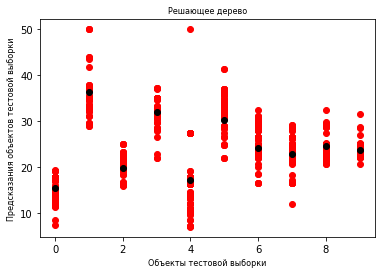

max_features =  11


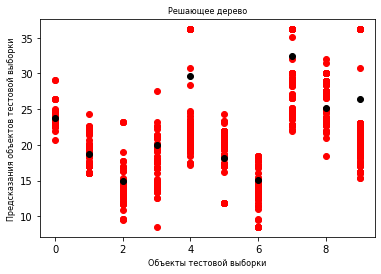

max_features =  12


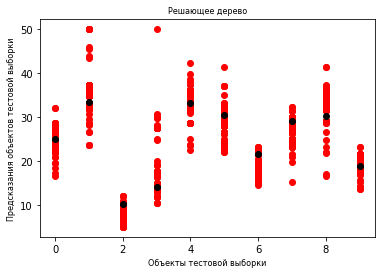

max_features =  13


In [674]:
for j  in range(1, X.shape[1]+1):

    plot_predictions(DecisionTreeRegressor(max_features = j), X, y, title = "Решающее дерево")
    print("max_features = ", j)




__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [715]:
### your code here
n_estimators1 = 2**np.arange(1, 8)

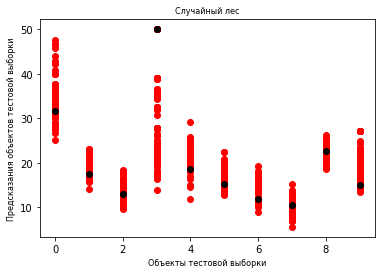

n_estimators =  2


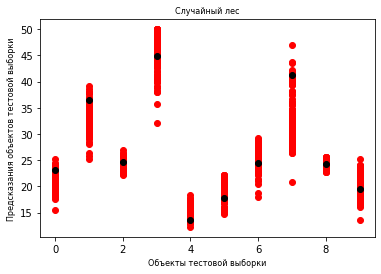

n_estimators =  4


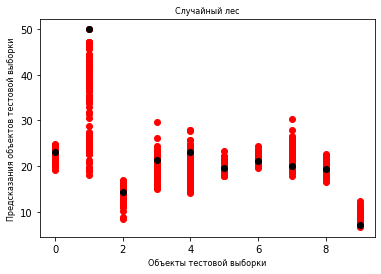

n_estimators =  8


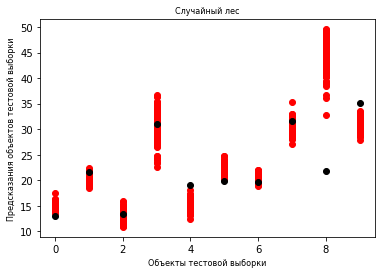

n_estimators =  16


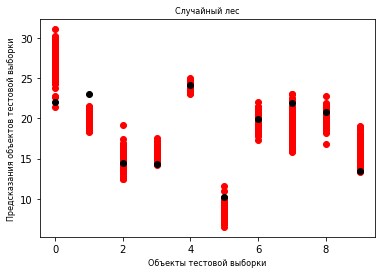

n_estimators =  32


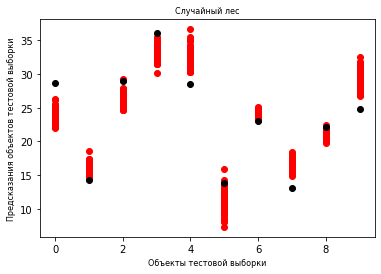

n_estimators =  64


In [704]:
for j  in n_estimators1:

    plot_predictions(RandomForestRegressor(n_estimators = j), X, y, title = "Случайный лес")
    print("n_estimators = ", j)

Для RF видно, что чем больше n_estimators, тем сильнее падает разброс.Что согласуется с теорией. Чем больше деревьев, тем меньше дисперсия.Смещение же остается примерно таким же.

In [712]:
from sklearn.ensemble import GradientBoostingRegressor

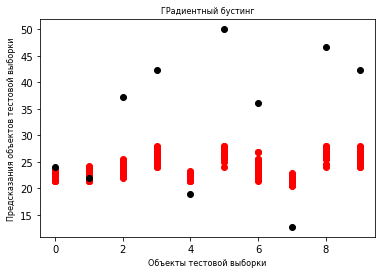

n_estimators =  2


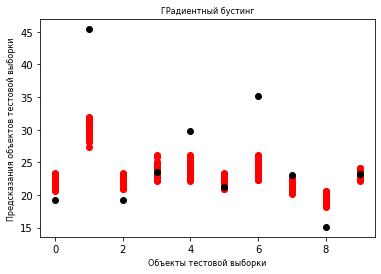

n_estimators =  4


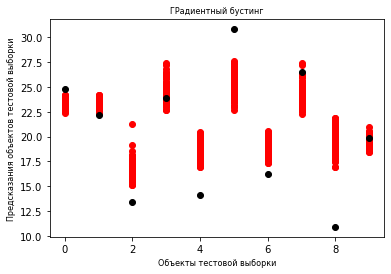

n_estimators =  8


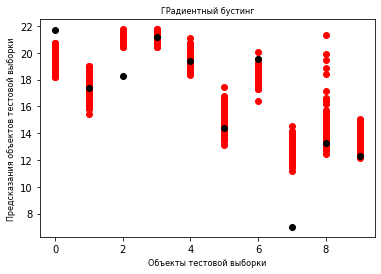

n_estimators =  16


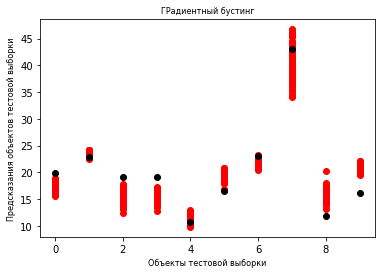

n_estimators =  32


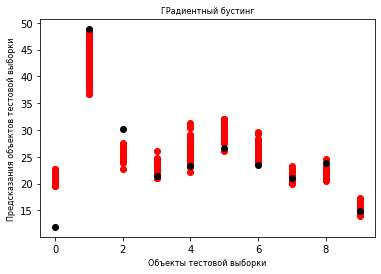

n_estimators =  64


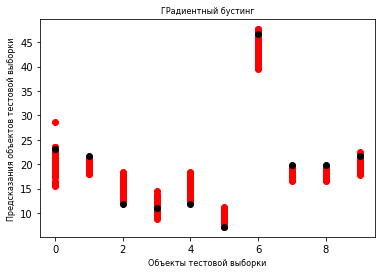

n_estimators =  128


In [717]:
for j  in n_estimators1:

    plot_predictions(GradientBoostingRegressor(n_estimators = j), X, y, title = "ГРадиентный бустинг")
    print("n_estimators = ", j)

Для бустинга уменьшается смещение и возрастает разброс.(Вначале плотненько распределены предсказания, потом начинают колебаться) Для маленьких значений большое значение смещения, но потом оно быстро падает и для n_estimators=64 уже лучше имеет смещение чем модели до этого.

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

Для max_depth видно, что смещение тем лучше, чем больше глубина. Разброс же увеличивается, ибо дерево начинает подстраивается под каждое наблюдение.

In [671]:
for j in range(1, 11):
    smes, error, variance = compute_biase_variance1(DecisionTreeRegressor(max_depth = j), X, y)
    print("max_depth = ", j,"смещение = ",  smes,"разброс = ",  variance)

max_depth =  1 смещение =  38.54553770907719 разброс =  13.672762480115923
max_depth =  2 смещение =  23.24748408703962 разброс =  7.5932558731199356
max_depth =  3 смещение =  16.5074156042763 разброс =  10.049678885276311
max_depth =  4 смещение =  13.560595404292595 разброс =  9.457618936668188
max_depth =  5 смещение =  11.921916569384916 разброс =  10.294583528203136
max_depth =  6 смещение =  11.489105364687996 разброс =  10.710078224138822
max_depth =  7 смещение =  10.962338453977468 разброс =  11.720761262024679
max_depth =  8 смещение =  10.345652454150168 разброс =  11.757072607739559
max_depth =  9 смещение =  10.271771140980919 разброс =  12.235272758272895
max_depth =  10 смещение =  10.14190634243727 разброс =  12.324884340298025


Как видно из расчета - смеещение на самом деле начинает падать. Разброс же в среднем возрастает.

Для max_features видно, что чем меньше признаков рассматривается - тем больше веротяность что мы какую-то информацию о модели теряем => большой разброс и большое смещение. Соответсвенно со временем они должны падать.


In [676]:
for j in range(1, X.shape[1]+1):
    smes, error, variance = compute_biase_variance1(DecisionTreeRegressor(max_features = j), X, y)
    print("max_features = ", j,"смещение = ",  smes,"разброс = ",  variance)

max_features =  1 смещение =  13.12991970033368 разброс =  28.930395436434612
max_features =  2 смещение =  11.100321187690533 разброс =  24.381688523852983
max_features =  3 смещение =  10.136081170750117 разброс =  21.17749803504711
max_features =  4 смещение =  9.405992991595479 разброс =  19.918621942626725
max_features =  5 смещение =  9.879761976642927 разброс =  18.18367708996604
max_features =  6 смещение =  9.55680041363651 разброс =  16.605864887177454
max_features =  7 смещение =  9.825256327074166 разброс =  15.944402072765554
max_features =  8 смещение =  9.669001879268087 разброс =  14.855866466767969
max_features =  9 смещение =  9.876838682604081 разброс =  13.480052845703858
max_features =  10 смещение =  10.087327433740027 разброс =  13.49832562165324
max_features =  11 смещение =  9.73252512366766 разброс =  13.561413130623958
max_features =  12 смещение =  10.0663849466532 разброс =  13.07732922155465
max_features =  13 смещение =  10.436370422771175 разброс =  13.0

In [708]:
for j  in n_estimators1:
    smes, error, variance = compute_biase_variance1(RandomForestRegressor(n_estimators = j), X, y)
    print("n_estimators = ", j,"смещение = ",  smes,"разброс = ",  variance)

n_estimators =  2 смещение =  11.103201014021872 разброс =  8.557719589588313
n_estimators =  4 смещение =  10.517941144646128 разброс =  4.996830616766125
n_estimators =  8 смещение =  10.56237029377444 разброс =  3.8159062260244765
n_estimators =  16 смещение =  10.092120557259685 разброс =  2.46104026580392
n_estimators =  32 смещение =  10.628843786316073 разброс =  2.469924723198919


Для этого прогона поменял в compute_biase_variance num_runs до 100, ибо на 1000 ждать долго. В целом тут данные подтверждают рисунок. Чем больше n_estimators тем ниже разброс. Смещение примерно такое же.

In [716]:
for j  in n_estimators1:
    smes, error, variance = compute_biase_variance1(GradientBoostingRegressor(n_estimators = j), X, y)
    print("n_estimators = ", j,"смещение = ",  smes,"разброс = ",  variance)

n_estimators =  2 смещение =  62.5530091377817 разброс =  0.37566689206117543
n_estimators =  4 смещение =  47.21524510696735 разброс =  0.6678845876911317
n_estimators =  8 смещение =  29.65927034490189 разброс =  0.9826177217458945
n_estimators =  16 смещение =  16.614368578805944 разброс =  1.4424187761233187
n_estimators =  32 смещение =  11.743054213925134 разброс =  1.9578928574444878
n_estimators =  64 смещение =  9.418978870482256 разброс =  1.7560758206217961
n_estimators =  128 смещение =  9.373977599274674 разброс =  2.105654391022734
